##### 導入stl模型，得到網格頂點位置以及網格平面

In [19]:
import igl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min
import skfuzzy as fuzz
import meshplot as mp

# 指定STL或OBJ檔案的路徑

stl_file_path = r"C:\alan\ITRI\Robot_Arm\input_obj\rounded_corners_cube2.obj"

# 從指定檔案讀取三角網格數據
v, f = igl.read_triangle_mesh(stl_file_path)

# 計算法向量
n = igl.per_vertex_normals(v, f)

# 將法向量歸一化
n_normalized = n / np.linalg.norm(n, axis=1)[:, np.newaxis]
print("v=",v)

v= [[14.    33.73   2.184]
 [14.    33.73  17.816]
 [14.    53.27   2.184]
 ...
 [34.    33.73  17.816]
 [34.    53.27   2.184]
 [34.    53.27  17.816]]


##### 計算每個網格平面的法向量

In [21]:
# 計算每個面的法向量
face_normals = np.cross(v[f[:, 1]] - v[f[:, 0]], v[f[:, 2]] - v[f[:, 0]])

# 將法向量歸一化
face_normals_normalized = face_normals / np.linalg.norm(face_normals, axis=1)[:, np.newaxis]

# 可以選擇將法向量存儲在f_normals中，其中每行對應於面f中相應的法向量
f_normals = face_normals_normalized

# 顯示結果（這僅是示例，實際應用可能需要進一步處理）
print("Face Normals:\n", f_normals)

Face Normals:
 [[ 0.92270059 -0.30348612 -0.23773893]
 [ 0.75476198 -0.51372022 -0.4079533 ]
 [ 0.75351663 -0.514463   -0.40931712]
 ...
 [ 0.82290189 -0.405527    0.39797026]
 [ 0.75440744 -0.37080792  0.54163724]
 [ 0.66237422 -0.61964824  0.42106585]]


##### 計算每個面的中心點座標

In [22]:
import igl
import numpy as np

# 初始化矩陣，每行表示一個面的中心點座標
face_centers = np.zeros((len(f), 3))

# 遍歷每個面，計算中心點座標為三個頂點座標的平均值
for i in range(len(f)):
    face_vertices = v[f[i], :]
    face_centers[i, :] = np.mean(face_vertices, axis=0)

print("每個面的中心點座標矩陣：")
print(face_centers.shape)



每個面的中心點座標矩陣：
(1772, 3)


##### 計算每個面的中心點平均曲率及高斯曲率

In [58]:
# v1, v2, k1, k2 = igl.principal_curvature(v, f)
# h=(k1+k2)/2#平均曲率
# k=k1*k2#高斯曲率

# # 計算每個面的平均曲率
# face_avg_curvatures = []
# for face in f:
#     avg_curvature = np.mean([h[face[0]], h[face[1]], h[face[2]]])
#     face_avg_curvatures.append(avg_curvature)
# face_avg_curvatures= np.array(face_avg_curvatures)

#### 計算每個面的平均曲率

In [23]:
v1, v2, k1, k2 = igl.principal_curvature(v, f)
h=(k1+k2)/2#平均曲率
k=k1*k2#高斯曲率

# 計算每個面的曲率(取三頂點中曲率絕對值最大值最為face的曲率)
face_curvatures = []
# 對於每個面的索引 face in f
for face in f:
    # 取出三個頂點的曲率值
    curvatures = [h[face[0]], h[face[1]], h[face[2]]]
    # 找到絕對值最大的曲率值
    max_curvature = max(curvatures, key=abs)
    # 將最大曲率值加入到列表中
    face_curvatures.append(max_curvature)

# 將 face_curvatures 轉換為 NumPy 陣列
face_curvatures = np.array(face_curvatures)

# 將法向量歸一化

# 計算向量的範數
norm_x = np.linalg.norm(face_curvatures)
# 對向量進行 L2 正規化
face_curvatures = face_curvatures/ norm_x


#### 高斯曲率

In [60]:
# 計算每個面的高斯曲率
face_guass_curvatures = []
for face in f:
    curvature = np.mean([k[face[0]], k[face[1]], k[face[2]]])
    face_guass_curvatures.append(curvature)
face_guass_curvatures=np.array(face_guass_curvatures)
    

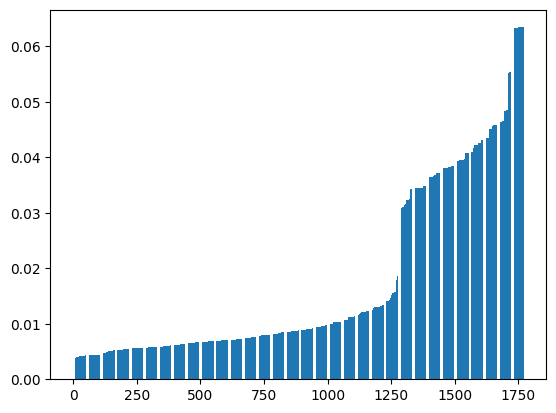

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(data):
    plt.bar(range(len(data)), data)
    plt.show()

curvature_distribute=np.sort(face_curvatures)

plot_bar_chart(curvature_distribute)

#### 顯示每個面(以中心點表示)的曲率分布

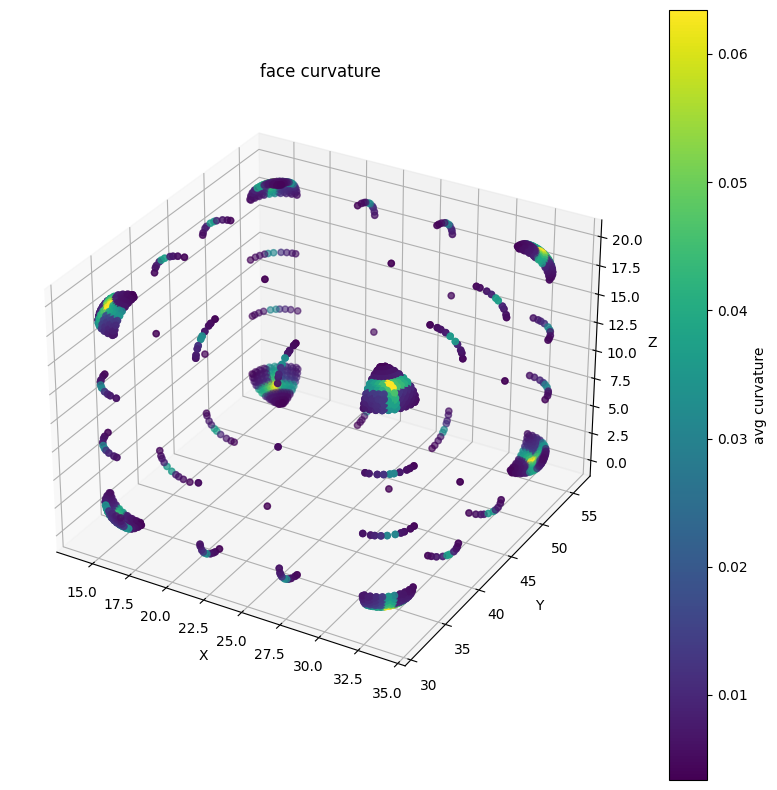

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 假設已經計算出了每個頂點的平均曲率，存儲在 h 中
# 假設已經有了頂點座標 v

# 創建一個3D圖形
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 提取頂點的X、Y、Z座標
x = face_centers[:, 0]
y = face_centers[:, 1]
z = face_centers[:, 2]

# 設置曲率對應的顏色
colors = face_curvatures  # 假設 h 包含了曲率信息

# 繪製頂點
ax.scatter(x, y, z, c=colors, cmap='viridis')

# 添加顏色條
cbar = plt.colorbar(ax.scatter(x, y, z, c=colors, cmap='viridis'))
cbar.set_label('avg curvature')

# 添加標籤和標題
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('face curvature')

# # 調整視角
# ax.view_init(elev=0, azim=0)

# 顯示圖形
plt.show()

In [70]:
selected_vertices = np.where(face_curvatures<0.13)[0]

cluster_faces = f[selected_vertices]
igl.write_triangle_mesh(f'cluster_face.stl', v, cluster_faces) 
mp.plot(v, cluster_faces, shading={"face": True}, c="red", lighting=True)

IndexError: index 1332 is out of bounds for axis 0 with size 1332

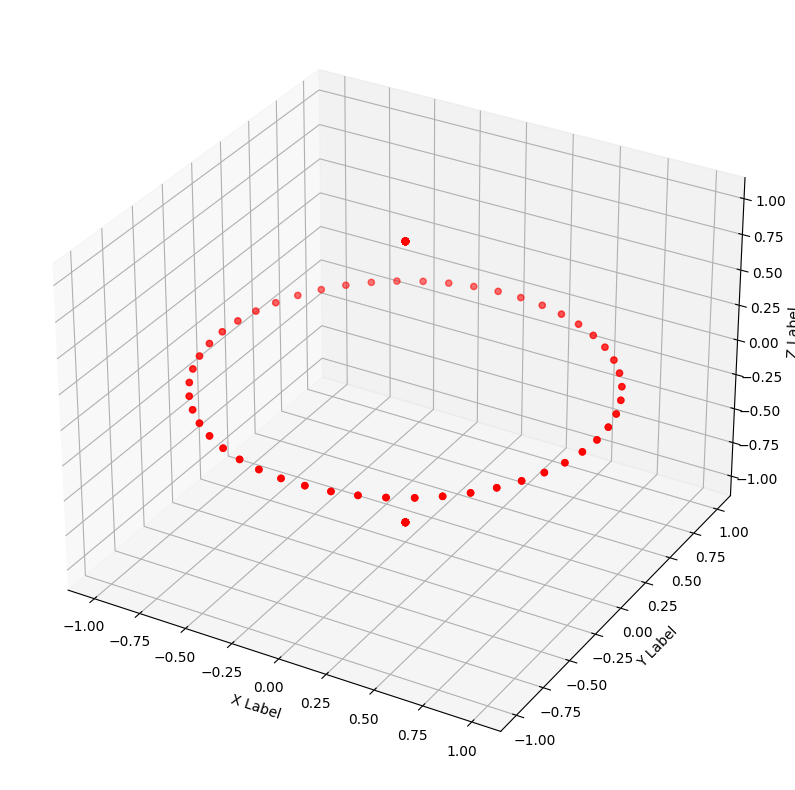

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成一些3D空間的測試數據
np.random.seed(42)
data =f_normals

# 創建3D圖
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', marker='o')

# 設定座標軸標籤
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 顯示圖形
plt.show()

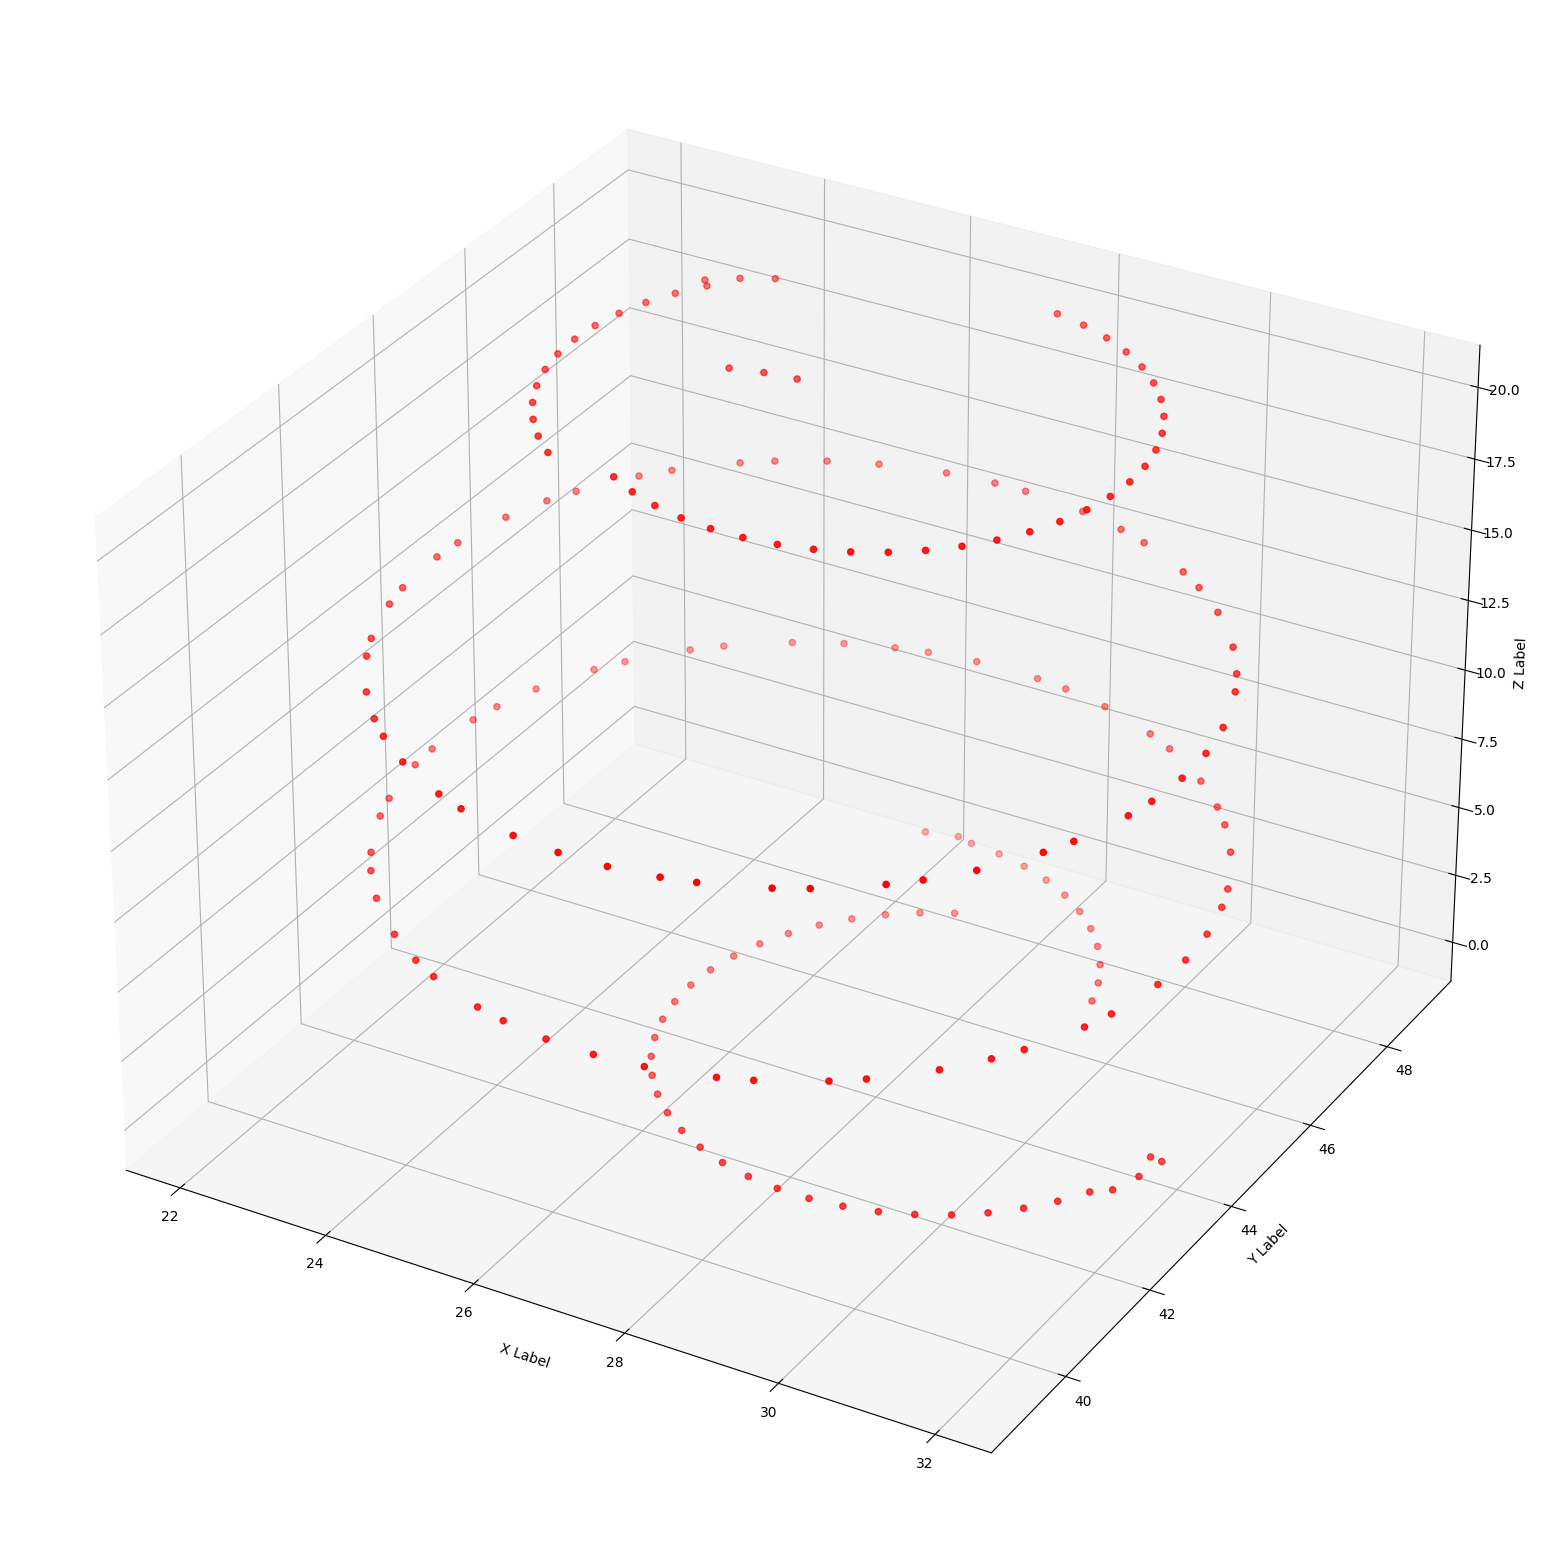

In [14]:
# 生成一些3D空間的測試數據
np.random.seed(42)
data =face_centers

# 創建3D圖
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', marker='o')

# 設定座標軸標籤
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 顯示圖形
plt.show()

## DBSCAN 分群

In [83]:
from sklearn.cluster import DBSCAN
# 使用 DBSCAN 算法進行分群
dbscan = DBSCAN(eps=0.25, min_samples=1)  # 根據需要調整參數
labels_db = dbscan.fit_predict(f_normals)
# labels_db=labels_db+1
# 將群組標籤轉換為整數
# labels = labels.astype(int)
np.savetxt('labels_bd.txt', labels_db, fmt='%d')
print(labels_db.dtype)
print(labels_db.shape)

int64
(196,)


In [74]:
unique_labels = np.unique(labels_db)
num_clusters = len(unique_labels)

print("分群數量：", num_clusters)

分群數量： 6


In [ ]:
f.shape

(12946, 3)

In [34]:
# from sklearn.cluster import DBSCAN
# # 使用 DBSCAN 算法進行分群
# dbscan = DBSCAN(eps=0.1, min_samples=1)  # 根據需要調整參數
# labels_db = dbscan.fit_predict(face_centers)
# # labels_db=labels_db+1
# # 將群組標籤轉換為整數
# # labels = labels.astype(int)
# np.savetxt('labels_bd.txt', labels_db, fmt='%d')
# print(labels_db.dtype)
# print(labels_db.shape)

int64
(2066,)


In [35]:
# unique_labels = np.unique(labels_db)
# num_clusters = len(unique_labels)

# print("分群數量：", num_clusters)

分群數量： 5


#### 根據DBSCAN分類結果，將不同簇的平面分別存成多個stl檔

In [51]:
# 準備可視化
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# 在左側的子圖中繪製原始三角網格
# ax0.set_title('Original Mesh')
# ax0.triplot(v[:, 0], v[:, 1], f)
rebuild=[]
# 在右側的子圖中繪製分群後的三角網格
# ax1.set_title('Clustered Mesh')
for cluster_label in range(num_clusters):
    cluster_indices = np.where(labels_db == cluster_label)[0]
    print(cluster_indices.shape)
    if len(cluster_indices) > 0:
        
        cluster_faces = f[cluster_indices]
        # cluster_vertices = v[cluster_faces[0]]
        print(cluster_faces)
        igl.write_triangle_mesh(f'cluster_n{cluster_label}.stl', v, cluster_faces)   ##這裡可能要修改，頂點應該只有 cluster_faces接觸的頂點才對
        rebuild.append(f'cluster_n{cluster_label}.stl')
            
# plt.show()

(3509,)
[[5844 6036 6041]
 [1072 1070 1073]
 [1071 1073 1070]
 ...
 [ 572  574 6159]
 [6159 5764  571]
 [ 571  572 6159]]
(3423,)
[[6259  277  279]
 [   1    3    2]
 [   2    0    1]
 ...
 [3969 3968 6474]
 [6474 3449 3969]
 [3440 3969 3449]]
(2902,)
[[1074 1075 1064]
 [1065 1064 1075]
 [1082 1083 1074]
 ...
 [ 648  640 5768]
 [5768 5307  684]
 [ 684  648 5768]]
(3020,)
[[1534 3126 1537]
 [1540 1537 3126]
 [1531 3127 1534]
 ...
 [2575 2574 2616]
 [2652 2698 2697]
 [2697 2696 2652]]
(46,)
[[ 546  556 4059]
 [4059 4058  546]
 [4058 4059 4063]
 [4063 4062 4058]
 [4062 4063 4067]
 [4067 4066 4062]
 [4066 4067 4071]
 [4071 4070 4066]
 [4070 4071 4075]
 [4075 4074 4070]
 [4074 4075 4079]
 [4079 4078 4074]
 [4078 4079 4083]
 [4083 4082 4078]
 [4082 4083 4087]
 [4087 4086 4082]
 [4086 4087 4091]
 [4091 4090 4086]
 [4090 4091 4095]
 [4095 4094 4090]
 [4094 4095 4099]
 [4099 4098 4094]
 [4098 4099 4103]
 [4103 4102 4098]
 [4102 4103 4107]
 [4107 4106 4102]
 [4106 4107 4111]
 [4111 4110 4106]
 [

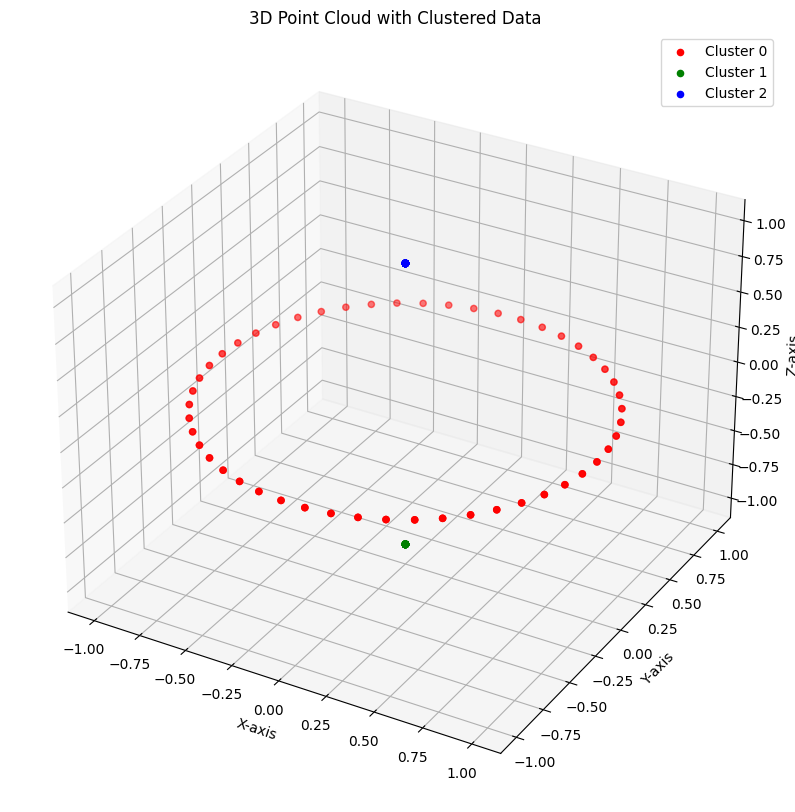

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# def generate_point_cloud(num_points, num_clusters):
#     # 生成 num_points 個隨機的三維點
#     points = np.random.rand(num_points, 3)

#     # 生成 num_clusters 個隨機的中心點
#     cluster_centers = np.random.rand(num_clusters, 3)

#     # 計算每個點屬於哪個群
#     labels = np.random.randint(0, num_clusters, num_points)

#     # 根據群的中心，使點離中心點有一些偏移
#     for i in range(num_clusters):
#         points[labels == i] += cluster_centers[i]

#     return points, labels

def plot_3d_point_cloud(points, labels):
    # 準備不同分群的顏色
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k','blue','pink','gray','purple','orange','cyan','green','olive','tan','gold','violet','hotpink','tomato']

    # 創建 3D 散點圖
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # 根據分群標籤繪製點
    for label in np.unique(labels):
        indices = labels == label
        ax.scatter(points[indices, 0], points[indices, 1], points[indices, 2], c=colors[label], label=f'Cluster {label}')

    # 設置標題和軸標籤
    ax.set_title('3D Point Cloud with Clustered Data')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # 顯示分群的圖例
    ax.legend()

    # 顯示散點圖
    plt.show()



# 顯示分群結果
plot_3d_point_cloud(f_normals, labels_db)

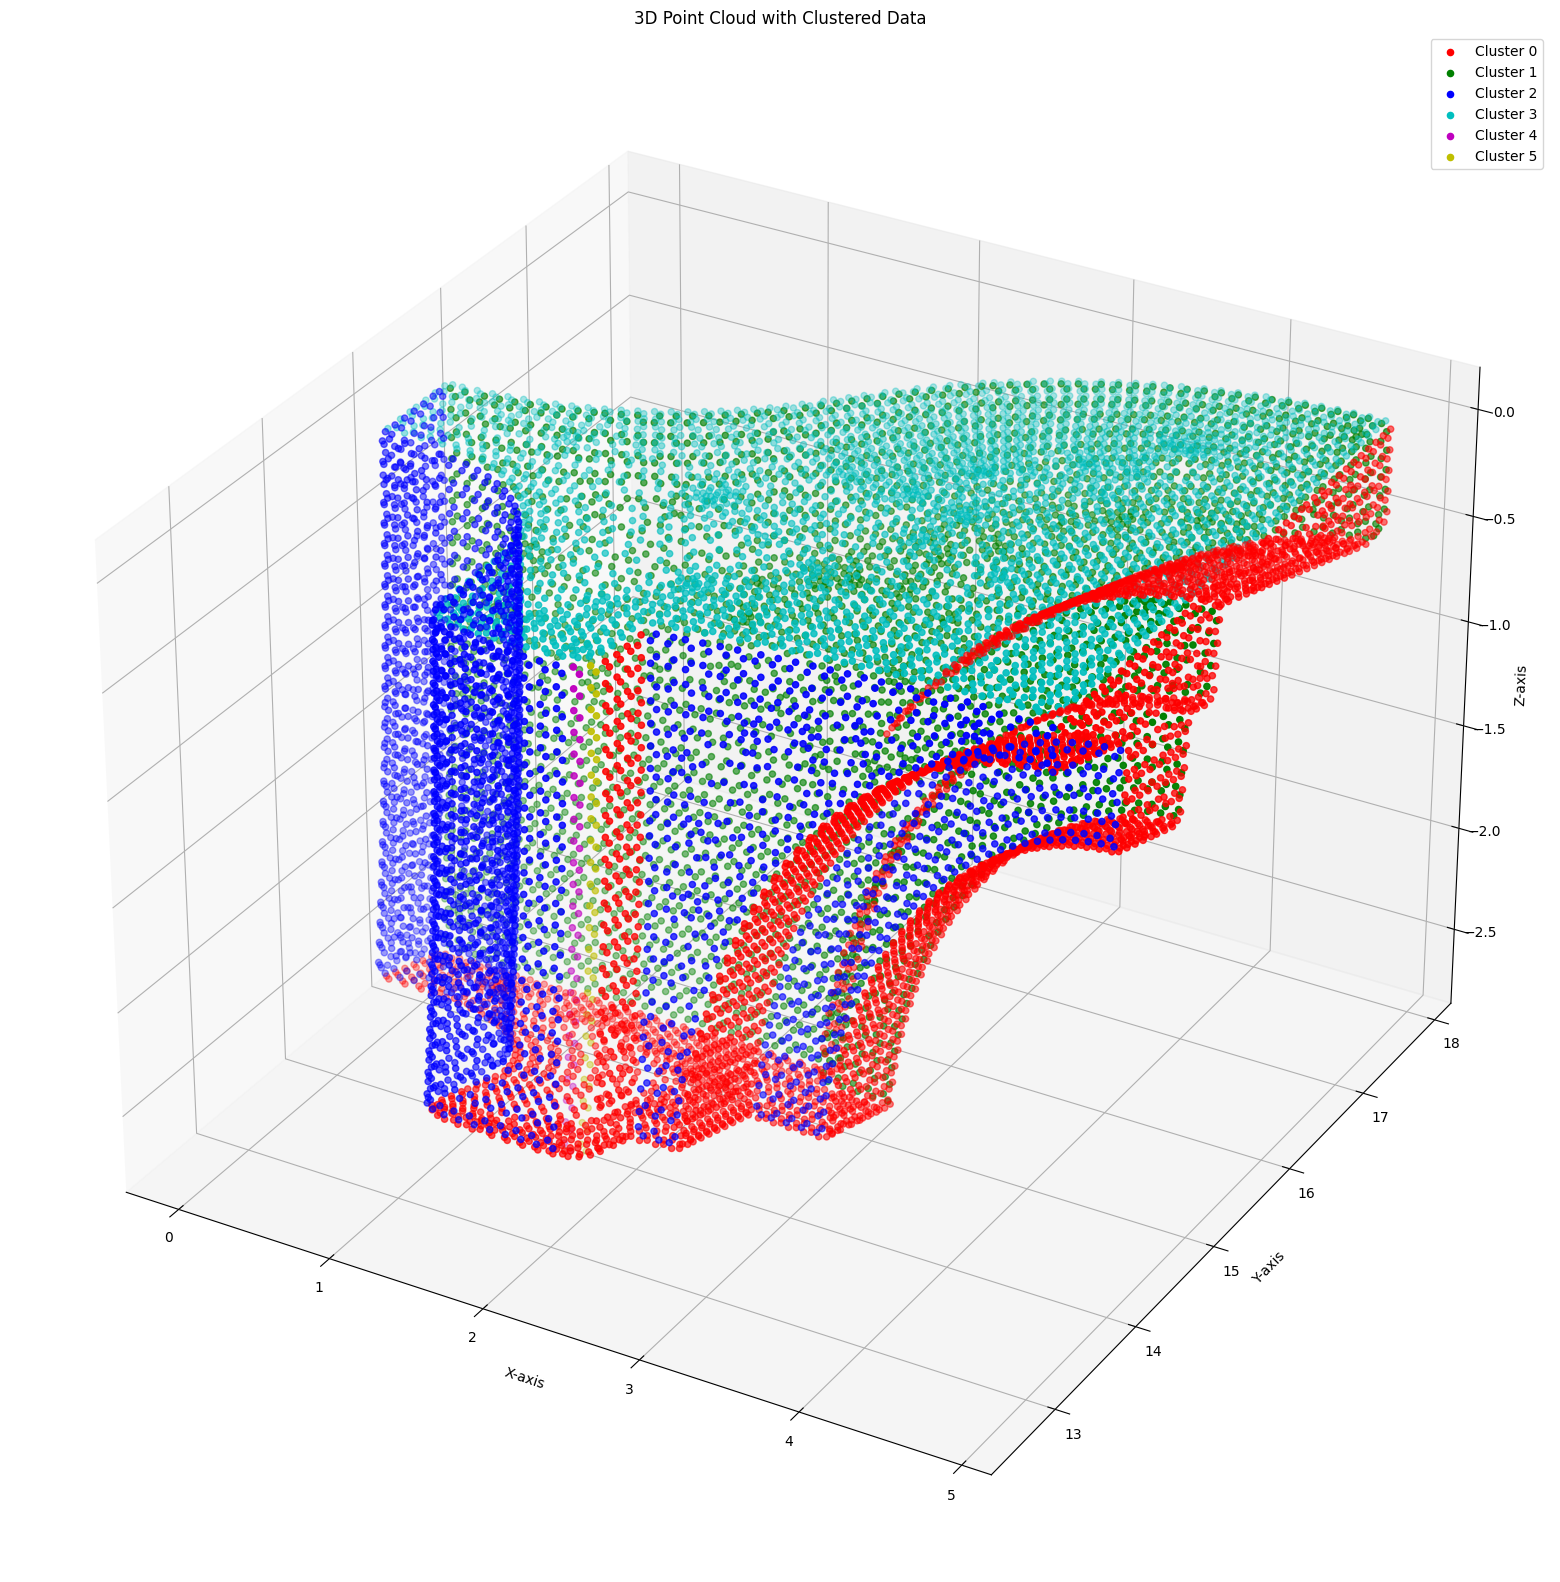

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_point_cloud(points, labels):
    # 準備不同分群的顏色
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k','blue','pink','gray','purple','orange','cyan','green','olive','tan','gold','violet','hotpink','tomato']

    # 創建 3D 散點圖
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')

    # 根據分群標籤繪製點
    for label in np.unique(labels):
        indices = labels == label
        ax.scatter(points[indices, 0], points[indices, 1], points[indices, 2], c=colors[label], label=f'Cluster {label}')

    # 設置標題和軸標籤
    ax.set_title('3D Point Cloud with Clustered Data')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # 顯示分群的圖例
    ax.legend()

    # 顯示散點圖
    plt.show()



# 顯示分群結果
plot_3d_point_cloud(face_centers, labels_db)

In [ ]:
from stl import mesh
# 將分割後的平面重組回去
def combine_stl_files(input_files, output_file):
    # 獲取每個STL檔案的頂點和三角形
    vertices = []
    triangles = []
    for stl_file in input_files:
        # 從指定檔案讀取三角網格數據
        mesh_data = mesh.Mesh.from_file(stl_file)
        for point in mesh_data.points:
            vertices.append(point)
        for triangle in mesh_data.vectors:
            triangles.append(triangle)
    
    # 創建新的STL檔案
    combined_mesh = mesh.Mesh(np.zeros(len(triangles), dtype=mesh.Mesh.dtype))
    combined_mesh.points = np.array(vertices)
    combined_mesh.vectors = np.array(triangles)

    # 保存合併後的STL檔案
    combined_mesh.save(output_file)


combine_stl_files(rebuild, 'combined_model.stl')

#### 將未相連的區域分開

In [1]:
import numpy as np
import igl
import os


def check_overlap(group1, group2):
    for row1 in group1:
        for row2 in group2:
            if np.any(row1 == row2):
                return True
    return False

def merge_groups(groups):
    merged = True
    while merged:
        merged = False
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                if check_overlap(groups[i], groups[j]):
                    groups[i] += groups[j]
                    del groups[j]
                    merged = True
                    break
            if merged:
                break
    return groups

def create_groups(matrix):
    groups = []
    for row in matrix:
        found_group = False
        for group in groups:
            if check_overlap(group, [row]):
                group.append(row)
                found_group = True
                break
        if not found_group:
            added_to_existing_group = False
            for group in groups:
                if any(check_overlap([row], existing_row) for existing_row in group):
                    group.append(row)
                    added_to_existing_group = True
                    break
            if not added_to_existing_group:
                groups.append([row])
    return groups


imput_path=r"C:\alan\ITRI\Robot_Arm\input_obj\2cubes.obj"
v, f = igl.read_triangle_mesh(imput_path)


groups = create_groups(f)
merged_groups = merge_groups(groups)

# 將每個群組存為獨立的.obj檔案
for idx, group in enumerate(merged_groups):
    if group:
        # 創建新的頂點和面數組以儲存當前群組
        group_faces = np.vstack(group)
        group_vertices = np.unique(group_faces.flatten())
        group_v = v[group_vertices]
        group_f = []
        for face in group_faces:
            group_f.append([np.where(group_vertices == vertex)[0][0] for vertex in face])
        group_f = np.array(group_f)

        # 將群組存為.obj檔案
        igl.write_triangle_mesh(f'group_{idx + 1}.obj', group_v, group_f)

print("total group=",len(merged_groups))

total group= 2


#### 觀察模型曲率分布

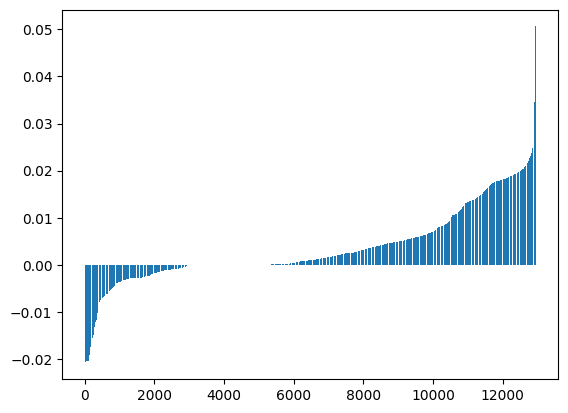

In [29]:
import os
import igl
import numpy as np

stl_file_path=r"C:\alan\ITRI\Robot_Arm\input_obj\fandisk.obj"
v, f = igl.read_triangle_mesh(stl_file_path)
v1, v2, k1, k2 = igl.principal_curvature(v, f)
h=(k1+k2)/2#平均曲率

# 計算每個面的曲率(取三頂點中曲率絕對值最大值最為face的曲率)
face_curvatures = []
# 對於每個面的索引 face in f
for face in f:
    # 取出三個頂點的曲率值
    curvatures = [h[face[0]], h[face[1]], h[face[2]]]
    # 找到絕對值最大的曲率值
    max_curvature = max(curvatures, key=abs)
    # 將最大曲率值加入到列表中
    face_curvatures.append(max_curvature)

# 將 face_curvatures 轉換為 NumPy 陣列
face_curvatures = np.array(face_curvatures)
# 將法向量歸一化
norm_x = np.linalg.norm(face_curvatures)
face_curvatures = face_curvatures/ norm_x

def plot_bar_chart(data):
    plt.bar(range(len(data)), data)
    plt.show()
curvature_distribute=np.sort(face_curvatures)
plot_bar_chart(curvature_distribute)